#**CIS 419/519**

## Deep Learning and Optuna worksheet 

In this worksheet, we use PyTorch libraries and packages to construct a simple neural network that classifies the handwritten digits in the MNIST dataset, a very common toy dataset for image classification. 

Our main goal will be to introduce you to Optuna, a library that will help you tune your hyperparameters.

---

###Pytorch Review
PyTorch is a Python-based scientific computing package serving two broad purposes:
*   Provide automatic differentiation in order to make it easy to implement neural networks.
*   Provide NumPy-like syntax with support for GPUs and other accelerator hardware in order to speed up these operators while making it easy for new users.

For more information and tutorials on PyTorch, go to:
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

https://pytorch.org/tutorials/

---



First, we import the required packages and libraries. Remember to change the runtime type to 'GPU' for faster runtime and fully utilize the power of PyTorch!

In [ ]:
# Import torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as thv
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset

# Import matplotlib for plotting
import matplotlib.pyplot as plt
 
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here, we load the MNIST dataset obtained from torchvision. Note that we can use the ToTensor() transformation on our downloaded data, which converts our data to a tensor, where the pixel values (0, 255) are scaled down to (0,1). However, we are going to do the same thing by hand to show you what's happening behind the scenes

In [ ]:
# Load the MNIST dataset from torchvision
train       = thv.datasets.MNIST('./', download=True, train=True)
val         = thv.datasets.MNIST('./', download=True, train=False)

# where we would include any transformations
# train       = thv.datasets.MNIST('./', download=True, train=True, transform= ToTensor())
# val         = thv.datasets.MNIST('./', download=True, train=False, transform= ToTensor())

Let's visualize one of the images, just to remind ourselves of what we are working with. As we see, each item is a 28x28 pixel picture of a handwritten digit (from 0-9).

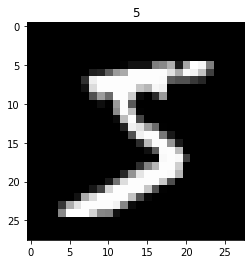

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train.data[0], cmap='gray')
plt.title('%i' % train.targets[0])
plt.show()

We perform pre-processing of the training and validation datasets, which include reshaping and normalization.

In [ ]:
# Reshape training and validation features from (batch_size,28,28) to (batch_size,28*28) and attach to GPU
# Note that the -1 means we are inferring that value from the other dimensions
xtrain            = train.data.view(-1, 28*28).to(device)
xval              = val.data.view(-1, 28*28).to(device)

# Normalize training and validation features from [0,255] to [0,1] 
xtrain            = xtrain/255.0
xval              = xval/255.0

# Attach training and validation labels to GPU
ytrain            = train.targets.to(device)
yval              = val.targets.to(device)

# Set training and validation dataloaders 
train_dataset     = TensorDataset(xtrain, ytrain)
train_dataloader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset       = TensorDataset(xval, yval)
val_dataloader    = DataLoader(val_dataset, batch_size=32, shuffle=False)

Next, we construct our neural network (NN). As an example, we use a 1-linear layer NN with ReLU activation functions.

In [ ]:
torch.manual_seed(1)
step          = 0
D_in, D_out   = 784, 10

# Neural network
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.ReLU(),
).to(device) # Remember to attach your model to GPU

As the performance metric/objective function, we use the cross entropy loss and we use stochastic gradient descent (SGD) as the optimization algorithm. The learning rate is set at `0.08` and we train for `25` epochs (full passes through the training data).



In [ ]:

torch.manual_seed(1)

# Initialization of training hyperparameters, cost function and optimizer
num_epochs    = 25
learning_rate = 0.08
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss    = 0.0
val_loss      = 0.0
total         = 0.0
num_correct   = 0.0
train_out     = torch.zeros(size=(num_epochs*len(train_dataloader), 2))
val_out       = torch.zeros(size=(torch.ceil(torch.mul(num_epochs*len(train_dataloader),0.002)).type(torch.int32), 2))
val_step      = 0

# Main training loop
for t in range(num_epochs):
  for idx, (x, y) in enumerate(train_dataloader, 0):
    # if we hadn't already flattened our data, we would do so before calling .to(device) on x
    x, y    = x.to(device), y.to(device) # Remember to attach your data to GPU

    # Required to zero gradient for each iteration
    optimizer.zero_grad()      
    # Get predicted label based on current model
    y_pred  = model(x)
    # Compute cost
    loss    = criterion(y_pred, y)
    # Do backpropagation
    loss.backward()

    # Compute average running training loss and accuracy
    total               += y.size(0)
    train_loss          += loss.item()*y.size(0)
    num_correct         += (torch.argmax(y_pred, dim=1) == y).sum().item()
    train_out[step,0]   = train_loss/total
    train_out[step,1]   = (num_correct/total)*100

    # Do validation once every 500 weight updates during training
    if step % 500 == 0:
      with torch.no_grad():
        val_loss            = 0.0
        total_val           = 0.0
        num_correct_val     = 0.0
        for idx, (x, y) in enumerate(val_dataloader, 0):
          x, y                  = x.to(device), y.to(device)
          y_pred                = model(x)
          loss                  = criterion(y_pred, y)   

          # Compute average running validation loss and accuracy       
          val_loss              += loss.item()*y.size(0)
          num_correct_val       += (torch.argmax(y_pred, dim=1) == y).sum().item()          
          total_val             += y.size(0)
          val_out[val_step,0]   = val_loss/total_val
          val_out[val_step,1]   = (num_correct_val/total_val)*100

        # Print some parameters for diagnosis
        print('No.:', step, 
                      ' Training Loss:', train_out[step,0].item(), ' Training Accuracy:', train_out[step,1].item(), 
                      ' Validation Loss:', val_out[val_step,0].item(), ' Validation Accuracy:', val_out[val_step,1].item())
        val_step               += 1

    optimizer.step()

    step    += 1

No.: 0  Training Loss: 2.256822347640991  Training Accuracy: 21.875  Validation Loss: 2.271984100341797  Validation Accuracy: 17.540000915527344
No.: 500  Training Loss: 0.8649508357048035  Training Accuracy: 76.1601791381836  Validation Loss: 0.6369289755821228  Validation Accuracy: 81.25
No.: 1000  Training Loss: 0.7417502999305725  Training Accuracy: 78.68069458007812  Validation Loss: 0.5823625922203064  Validation Accuracy: 81.80000305175781
No.: 1500  Training Loss: 0.690576434135437  Training Accuracy: 79.69270324707031  Validation Loss: 0.5548501014709473  Validation Accuracy: 82.31999969482422
No.: 2000  Training Loss: 0.6623077392578125  Training Accuracy: 80.14273834228516  Validation Loss: 0.5376133322715759  Validation Accuracy: 82.70999908447266
No.: 2500  Training Loss: 0.6411467790603638  Training Accuracy: 80.53653717041016  Validation Loss: 0.5288902521133423  Validation Accuracy: 83.01000213623047
No.: 3000  Training Loss: 0.6249848008155823  Training Accuracy: 80.83

Finally, we plot the training and validation losses and accuracies as a function of the number of weight updates (iterations of training).

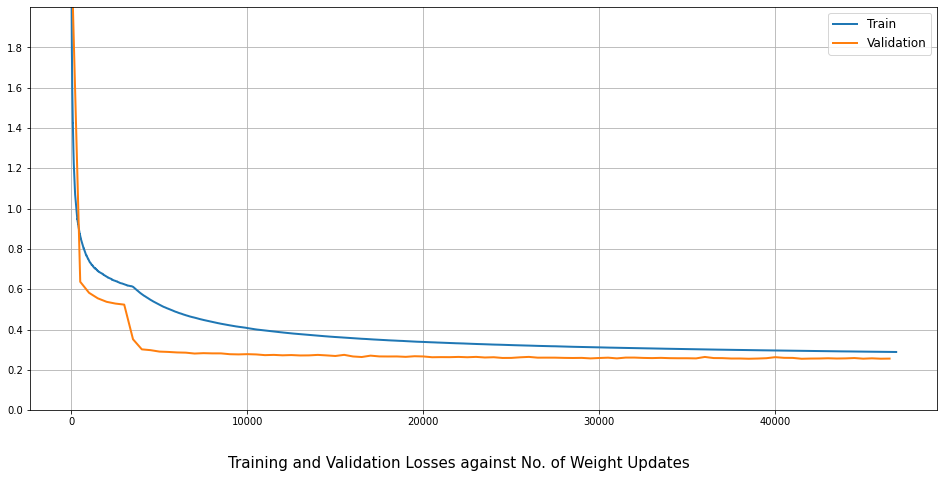

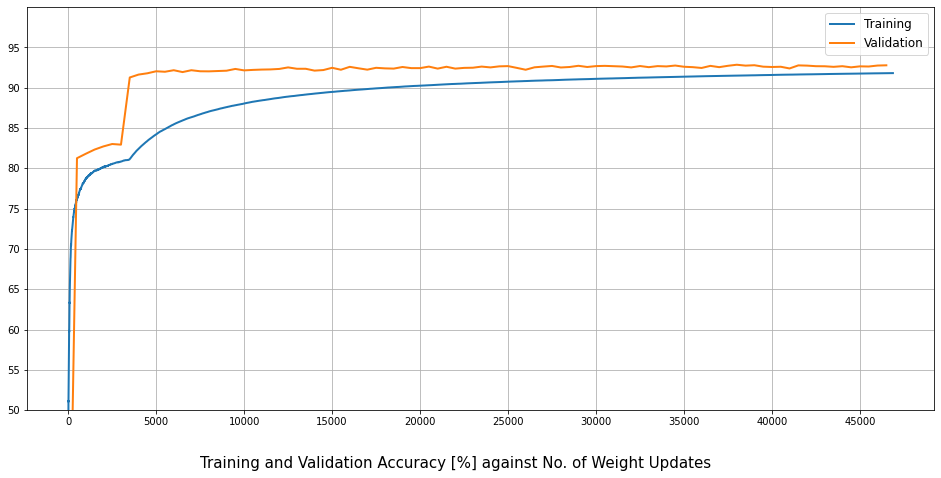

In [ ]:
t_train       = torch.arange(train_out.shape[0])
t_val         = torch.arange(val_out.shape[0])

fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_axes((0.0, 0.2, 1.8, 0.7))
ax1.plot(t_train, train_out[:,0], lw=2)
ax1.plot(t_val*500, val_out[:,0], lw=2)
ax1.grid('on')
ax1.set_yticks(torch.arange(0, 2, step=0.2)) 
ax1.set_ylim(bottom=0, top=2)
ax1.legend(['Train','Validation'], fontsize=12)
# center text
fig.text(.85, .1, 'Training and Validation Losses against No. of Weight Updates', ha='center', size=15)
fig.set_size_inches(7, 8, forward=True)

fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_axes((0.0, 0.2, 1.8, 0.7))
ax1.plot(t_train, train_out[:,1], lw=2)
ax1.plot(t_val*500, val_out[:,1], lw=2)
ax1.grid('on')
ax1.set_xticks(torch.arange(0, 48000, step=5000)) 
ax1.set_yticks(torch.arange(50, 100, step=5)) 
ax1.set_ylim(bottom=50, top=100)
ax1.legend(['Training','Validation'], fontsize=12)
# center text
fig.text(.85, .1, 'Training and Validation Accuracy [%] against No. of Weight Updates', ha='center', size=15)
fig.set_size_inches(7, 8, forward=True)

plt.show()


## Hyperparameter Tuning- Can we do better than Grid Search?

Hyperparameter tuning can be one of the most impactful (and computationally expensive) processes on a machine learning model's performance. So far, we mainly think of hyperparameter tuning in terms of nested loops, or a grid, in a sense. In this method, we might feed our model a few reasonable options for different hyperparameters and train our model for each combination, ultimately choosing the combination that results in best performance.

This is certainly a useful method, but can be inefficient, particularly when some areas of our hyperparameter distribution have a low likelihood of performing well. We have to re-evaluate the objective function for each combination, so while this method could be useful for simple models with few hyperparameter options, it starts to scale poorly when our models become more complex and when we introduce more hyperparameters.

### Enter Bayesian Optimization 

In this method, instead of simply looping through arrays of hyperparameters, we build a probability model (called a surrogate) mapping the probability of different sets of hyperparameters achieving various scores on our objective function. It's important to note that while this model might not be very accurate on the first try, we will iterate on it to make it better.

Instead of evaluating hyperparameters on the objective function, we evaluate some sort of selection criterion on the surrogate, which is much easier to compute. An example of a commonly used selection criteria is Expected Improvement:
<br><br>

$EI_{y^*}(x) = \int_{-\infty}^{y^*}(y^*-y)p(y|x)dy$,

<br>

where $y^*$ corresponds to some threshold value of the objective function, $x$ is the proposed set of hyperparameters, $y$ is the actual value of the objective function using hyperparameters $x$, and $p(y|x)$ is the surrogate probability model expressing the probability of $y$ given $x$. You can tell by looking at the equation that this function will be higher when we have higher probabilities for smaller values of $y$. When this function is high, it represents greater expected improvement, and thus **we aim to maximize it.** 

When we have chosen our best set of hyperparameters for the surrogate, we evaluate on the real objective function. We then keep iterating on our surrogate based on our history of these scores, to make our surrogate more closely spproximate our actual objective function.

The key to Bayesian Optimization is that, with each iteration, **we are using our prior knowledge to help select better sets of hyperparameters.** Thus, while we spend more time selecting each set of hyperparameters, we are selecting better hyperparameters, and thus **can minimize our error with fewer calls of the objective function.** When calling the objective function involves training a complicated neural network, the extra time spent selecting each hyperparameter set becomes negligible when compared to the time saved by training the actual model fewer times.

For a deeper dive into Bayesian Optimization, we highly recommend you check out [this tutorial](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f).

## Bayesian Optimization in Practice With Optuna

As fun as implementing the above Bayesian Optimization technique from scratch sounds, other people have actually already done it for us! 

Using Optuna, we create a study based off parameter distributions we choose and a study length we choose (which we can specify in number of trials or in seconds). Optuna then uses a Bayesian sampler to choose the best hyperparameters within our given distributions and ultimatley give us the best hyperparameter set it can find. The default sampler is the Tree-structured Parzen Estimator, which is demonstrated in the above linked tutorial, but we can choose a different sampler if we wish. 

To use Optuna, we should familiarize ourselves with the ideas of suggested parameter distributions, trials, and pruning.

**Suggested parameter distributions** allow us to define our search space via a minimum, maximum, and probability distribution. Optuna allows us to use any of the following distributions:


*   uniform — float values
*   log-uniform — float values
*   discrete uniform — float values with intervals
*   integer — integer values
*   categorical — categorical values from a list


We can use these distributions to constrict our search spaces to ones that make sense for each parameter. For instance, if we wanted to tune the depth of a decision tree, it wouldn't make sense to include floats like 3.7 in our search space, so constain it to integers.

For perhaps a less obvious example, we can look at learning rate. Based on prior knowledge, we know that an efficient way of tuning learning rate is to follow a log-normal distribution over several orders of magnitude; we generally want to change the learning rate by multiplying it by a value rather than adding a value ([source](https://www.kdnuggets.com/2017/11/estimating-optimal-learning-rate-deep-neural-network.html)). Thus, while it would not necessarily be nonsensical to simply pick from a uniform distribution of floats, it could be much more effective to pick from a log-uniform distribution.

**Trials** simply refer to every time the objective function is called. So, for each trial, we use our Bayesian sampler to select a set of hyperparameters, then evaluate that set on our actual data (usually through cross-validation).

**Pruning** refers to Optuna stopping trials early based on some measure that suggests it might not perform well. After a certain number of trials, we can tell Optuna to start looking at the intermediate values of our trials and compare them to past trials, stopping early if they compare poorly (based on some measure we set). This helps speed up the process, as we spend less time on trials that might have little impact. We define the type of pruner when we create our study, the default being the Median Pruner, where a trial is pruned if its best intermediate result is worse than median of intermediate results of previous trials at the same step. To enable pruning, we simply call the report() and should_prune() methods after each step of the training.


In [ ]:
import os

!pip install optuna
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 209 kB 46.5 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 111 kB 49.2 MB/s 
     |████████████████████████████████| 144 kB 49.0 MB/s 
     |████████████████████████████████| 49 kB 6.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d1c4679447350df63c4e7e5e9bd7f090c707e69d59bee9449ff628da2cff8b32
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
DEVICE = device
CLASSES = 10
EPOCHS = 10

In [ ]:
def define_model(trial):
    # We optimize the number of layers and hidden units in each layer.
    # We give Optuna the distibution to sample from using "suggest"
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 16, 32)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader, valid_loader = train_dataloader, val_dataloader

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.view(data.shape[0], -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.view(data.shape[0], -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                
        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        # The rule used for pruning is defined in the create_study function 
        # in the next cell, where the default uses a Median pruner, which stops 
        # the trial if the trial’s best intermediate result is worse than the 
        # median of intermediate results of previous trials at the same step
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
# We are returning accuracy, so we want to maximize it
study = optuna.create_study(direction="maximize")
# Set our study to stop after either 100 trials or 300 seconds
study.optimize(objective, n_trials=100, timeout=300)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-10-20 17:51:18,719] A new study created in memory with name: no-name-33d4cf39-f2d2-4a06-a564-a223caea7674
[I 2021-10-20 17:52:13,205] Trial 0 finished with value: 0.9561 and parameters: {'n_layers': 3, 'n_units_l0': 19, 'n_units_l1': 28, 'n_units_l2': 24, 'optimizer': 'Adam', 'lr': 0.00048174552663188047}. Best is trial 0 with value: 0.9561.
[I 2021-10-20 17:52:46,442] Trial 1 finished with value: 0.9382 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'optimizer': 'RMSprop', 'lr': 0.008410522136014864}. Best is trial 0 with value: 0.9561.
[I 2021-10-20 17:53:19,559] Trial 2 finished with value: 0.9465 and parameters: {'n_layers': 1, 'n_units_l0': 31, 'optimizer': 'RMSprop', 'lr': 0.00020009870263194748}. Best is trial 0 with value: 0.9561.
[I 2021-10-20 17:54:07,206] Trial 3 finished with value: 0.9394 and parameters: {'n_layers': 3, 'n_units_l0': 31, 'n_units_l1': 29, 'n_units_l2': 24, 'optimizer': 'RMSprop', 'lr': 0.0001149716951007059}. Best is trial 0 with value: 0.9561.


Study statistics: 
  Number of finished trials:  12
  Number of pruned trials:  4
  Number of complete trials:  8
Best trial:
  Value:  0.9579
  Params: 
    n_layers: 2
    n_units_l0: 16
    n_units_l1: 24
    optimizer: SGD
    lr: 0.08266189923068824


Once we finish our study, Optuna provides some handy convenience functions. We can select our best parameters, and even view our trials as a pandas dataframe!

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_lr,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_optimizer,state
0,0,0.9561,2021-10-20 17:51:18.723246,2021-10-20 17:52:13.204965,0 days 00:00:54.481719,0.000482,3,19,28.0,24.0,Adam,COMPLETE
1,1,0.9382,2021-10-20 17:52:13.207569,2021-10-20 17:52:46.442287,0 days 00:00:33.234718,0.008411,1,16,NaN,NaN,RMSprop,COMPLETE
2,2,0.9465,2021-10-20 17:52:46.445529,2021-10-20 17:53:19.558758,0 days 00:00:33.113229,0.000200,1,31,NaN,NaN,RMSprop,COMPLETE
3,3,0.9394,2021-10-20 17:53:19.560999,2021-10-20 17:54:07.205859,0 days 00:00:47.644860,0.000115,3,31,29.0,24.0,RMSprop,COMPLETE
4,4,0.6009,2021-10-20 17:54:07.208417,2021-10-20 17:54:35.545007,0 days 00:00:28.336590,0.000145,1,21,NaN,NaN,SGD,COMPLETE
5,5,0.1562,2021-10-20 17:54:35.547037,2021-10-20 17:54:38.368935,0 days 00:00:02.821898,0.000041,1,20,NaN,NaN,SGD,PRUNED
6,6,0.9576,2021-10-20 17:54:38.370816,2021-10-20 17:55:16.857636,0 days 00:00:38.486820,0.042099,3,20,27.0,17.0,SGD,COMPLETE
7,7,0.1135,2021-10-20 17:55:16.860062,2021-10-20 17:55:20.786726,0 days 00:00:03.926664,0.000212,3,26,16.0,18.0,SGD,PRUNED
8,8,0.0965,2021-10-20 17:55:20.788570,2021-10-20 17:55:24.621792,0 days 00:00:03.833222,0.000027,3,25,31.0,16.0,SGD,PRUNED
9,9,0.8736,2021-10-20 17:55:24.624985,2021-10-20 17:55:30.138505,0 days 00:00:05.513520,0.000174,3,32,21.0,25.0,Adam,PRUNED


In [ ]:
study.best_params

{'lr': 0.08266189923068824,
 'n_layers': 2,
 'n_units_l0': 16,
 'n_units_l1': 24,
 'optimizer': 'SGD'}


For more information about Optuna, refer to [this tutorial](https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af) or [Optuna's documentation](https://optuna.readthedocs.io/en/stable/tutorial/index.html).